In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
#import matplotlib.pyplot as plt
import subprocess
from scipy import spatial
import os
import sys
from tqdm import tqdm
import deeptime
import torch
import matplotlib.pyplot as plt
print(os.getcwd())

/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/notebooks


In [3]:
T_list = [0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]

In [6]:
inputs_list = []

for T in T_list:
    inputs = np.load('thermomaps-gayberne/%sT/orientations.npy' % T)
    inputs_list.append(inputs)

In [3]:
inputs_modified = np.column_stack([inputs[:,:2], inputs[:,4:]])

In [4]:
inputs.shape

(200309, 6)

In [5]:
from deeptime.decomposition.deep import TVAEEncoder
encoder = TVAEEncoder([6, 64, 64, 2], nonlinearity=torch.nn.ReLU)
print(encoder)

TVAEEncoder(
  (_sequential): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (_to_mu): Linear(in_features=64, out_features=2, bias=True)
  (_to_logvar): Linear(in_features=64, out_features=2, bias=True)
)


In [8]:
from deeptime.util.torch import MLP
decoder = MLP([2, 64, 64, 6], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [67]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, inputs.astype(np.float32))

n_val = int(len(dataset)*.5)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=4, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [69]:
from deeptime.decomposition.deep import TVAE

tvae = TVAE(encoder, decoder, learning_rate=1e-5)
tvae.fit(loader_train, n_epochs=50, validation_loader=loader_val)
tvae_model = tvae.fetch_model()


KeyboardInterrupt



In [ ]:
plt.semilogy(*tvae.train_losses.T, label='train')
plt.semilogy(*tvae.validation_losses.T, label='validation')
plt.legend();

In [ ]:
z = tvae_model.transform(inputs)

In [ ]:
plt.plot(z)

In [170]:
units = [4, 16, 16, 2]
encoder = MLP(units, nonlinearity=torch.nn.ReLU, output_nonlinearity=torch.nn.Sigmoid,
              initial_batchnorm=False)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, inputs_modified.astype(np.float32))

n_val = int(len(dataset)*.5)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

loader_train = DataLoader(train_data, batch_size=256, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

from deeptime.decomposition.deep import TAE

tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=250, validation_loader=loader_val)
tae_model = tae.fetch_model()

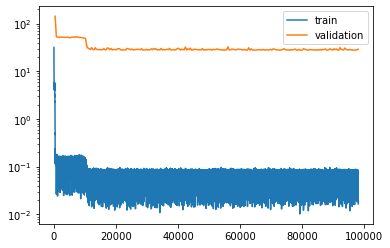

In [171]:
plt.semilogy(*tae.train_losses.T, label='train')
plt.semilogy(*tae.validation_losses.T, label='validation')
plt.legend();

In [172]:
z = tae_model.transform(inputs_modified)

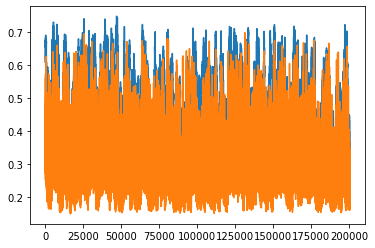

In [173]:
plt.plot(z)

(array([[0.0000e+00, 1.0700e+02, 1.5686e+04, 3.2243e+04, 3.2783e+04,
         3.5132e+04, 3.8836e+04, 3.0952e+04, 1.3136e+04, 1.4340e+03],
        [1.7174e+04, 6.2932e+04, 6.2063e+04, 3.4618e+04, 1.5158e+04,
         5.7210e+03, 1.9010e+03, 5.9500e+02, 1.4400e+02, 3.0000e+00]]),
 array([0.14869109, 0.20874776, 0.26880443, 0.32886109, 0.38891774,
        0.44897443, 0.50903106, 0.56908774, 0.62914443, 0.68920106,
        0.74925774]),
 <a list of 2 BarContainer objects>)

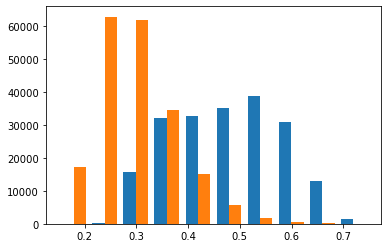

In [174]:
plt.hist(z)

/tmp/ipykernel_109865/2562680286.py:8: RuntimeWarning: divide by zero encountered in log
  fes = -np.log(hist)


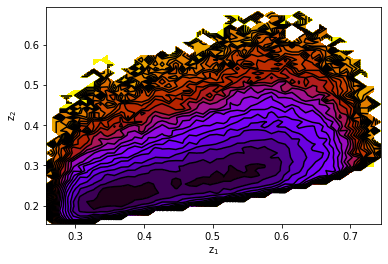

In [177]:
hist, xbins, ybins = np.histogram2d(z[:,0], z[:,-1], bins = 50)
xbins = (xbins[1:] + xbins[:-1]) / 2
ybins = (ybins[1:] + ybins[:-1]) / 2

hist = hist / hist.sum()
hist = hist.T

fes = -np.log(hist)
fes = fes - fes.min()

xx, yy = np.meshgrid(xbins, ybins)
plt.contour(xx, yy, fes, levels = 25, colors = 'k')
plt.contourf(xx, yy, fes, levels = 25, cmap = 'gnuplot')
plt.xlabel('z$_1$')
plt.ylabel('z$_2$')
plt.show()
plt.close()

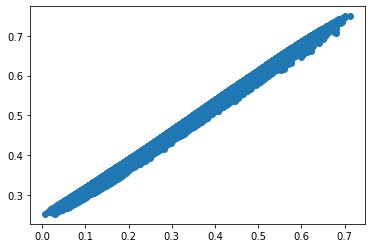

In [176]:
plt.scatter(inputs[:,0], z[:,0])

In [41]:
np.corrcoef(z[:,1], inputs[:,6])

IndexError: index 6 is out of bounds for axis 1 with size 6

In [178]:
np.save('z_vae_nematic.npy', z)